# Analysis of COVID-19 Cases per County in the United States
#### Data retrieved from the Center for Systems Science and Engineering at Johns Hopkins University on April 13

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
cases = pd.read_csv("coviddata_johnshopkins_april131248pm.txt")

In [3]:
cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,84,93,112,113,121,121,128,130,133,133
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,6,6,6,6,6,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,316,452,475,513,573,620,683,725,788,897
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,37,40,42,43,43,45,45,50,51,51


In [4]:
USA = cases.loc[cases['iso3'] == 'USA']
dates = USA.columns[11:]

In [5]:
# Function to plot the cumulative number of records for a specified county-state combo
def cumulative(county, state):
    fig = plt.figure(figsize=(18,12))
    plt.plot(USA[(USA.Admin2 == county) & (USA.Province_State == state)].iloc[0,11:])
    plt.xticks(rotation = 60)
    plt.title('Cumulative Number of Cases for {}, {}'.format(county, state))
    plt.ylabel('Number of Cases')
    #return np.cumsum(USA.loc[USA.Admin2 == county][USA.Province_State == state].iloc[0,11:])

Text(0, 0.5, 'Cumulative Number of Cases')

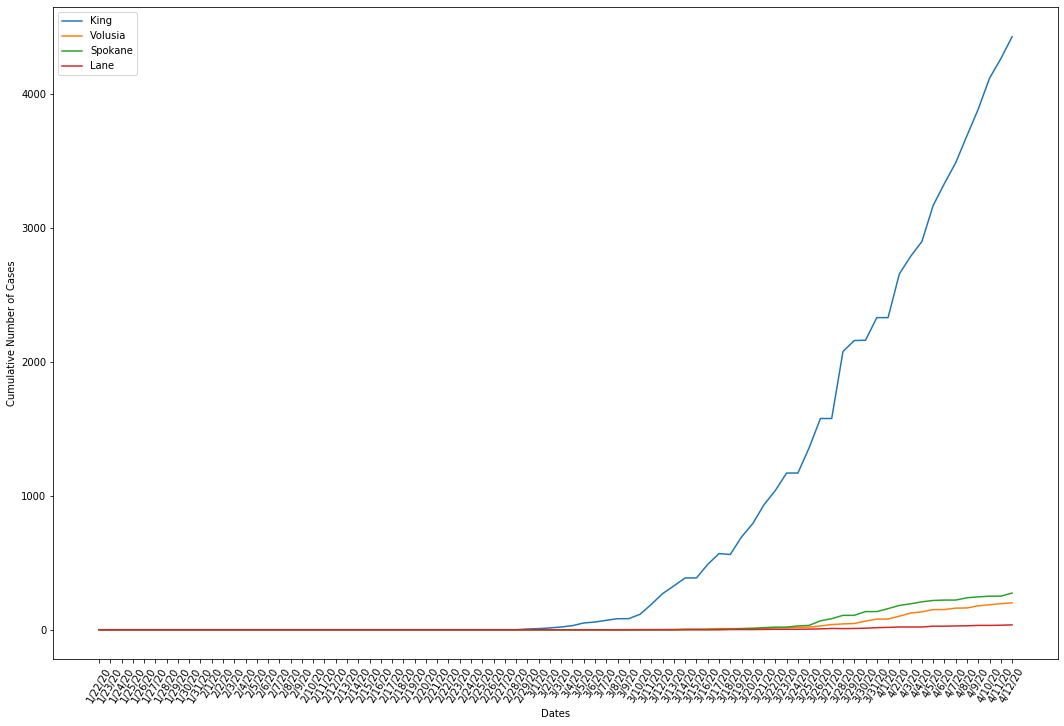

In [6]:
# Plot Multiple Counties
fig,ax = plt.subplots(figsize=(18,12))
plt.xticks(rotation = 60)
plt.plot(USA[(USA.Admin2 == 'King') & (USA.Province_State == 'Washington')].iloc[0,11:], label = 'King')
plt.plot(USA[(USA.Admin2 == 'Volusia') & (USA.Province_State == 'Florida')].iloc[0,11:], label = 'Volusia')
plt.plot(USA[(USA.Admin2 == 'Spokane') & (USA.Province_State == 'Washington')].iloc[0,11:], label = 'Spokane')
plt.plot(USA[(USA.Admin2 == 'Lane') & (USA.Province_State == 'Oregon')].iloc[0,11:], label = 'Lane')


legend = ax.legend(loc='upper left') # have a legend box (since now we have colors) and place it top left so it doesn't obscure things
#plt.title('CGPA vs Chance of Admission, Differentiated on Research')
plt.xlabel('Dates')
plt.ylabel('Cumulative Number of Cases')

In [7]:
def percentage_growth(county, state):
    first_occur = [USA[(USA.Admin2 == county) & (USA.Province_State == state)].iloc[0,11:][i] != 0 for i in range(len(dates))]
    impacted_dates = USA[(USA.Admin2 == county) & (USA.Province_State == state)].iloc[0,11:][first_occur]
    final = max(impacted_dates)
    first = min(impacted_dates)
    return round(((final - first)/first)*100,1)

In [8]:
percentage_growth('Spokane', 'Washington')

9033.3

In [9]:
# Function to plot daily percentage change in new cases
def daily_change(county, state, metric):
    # Boolean mask of when the county had its first case
    first_occur = [USA[(USA.Admin2 == county) & (USA.Province_State == state)].iloc[0,11:][i] != 0 for i in range(len(dates))]
    # Reduce analysis to only the dates when the county had an infection
    impacted_dates = USA[(USA.Admin2 == county) & (USA.Province_State == state)].iloc[0,11:][first_occur]   
    
    if metric == 'percentage':
        # Plot the results
        fig = plt.figure(figsize=(18,12))
        plt.plot(dates[first_occur][:-1], [((impacted_dates[i+1]-impacted_dates[i])/impacted_dates[i])*100 for i in range(len(impacted_dates)-1)])
        plt.xticks(rotation = 60)
        plt.title('Percentage Change in Number of New Cases from the Previous Day for {}, {}'.format(county, state))
        plt.ylabel('Percentage Change in Number of New Cases from Previous Day')
    elif metric == 'daily':
        fig = plt.figure(figsize=(18,12))
        plt.plot(dates[first_occur][:-1], [impacted_dates[-i]-impacted_dates[-i-1] for i in range(len(impacted_dates))][::-1][:-1])
        plt.xticks(rotation = 60)
        plt.title('Change in Number of New Cases from the Previous Day for {}, {}'.format(county, state))
        plt.ylabel('Change in Number of New Cases from Previous Day')

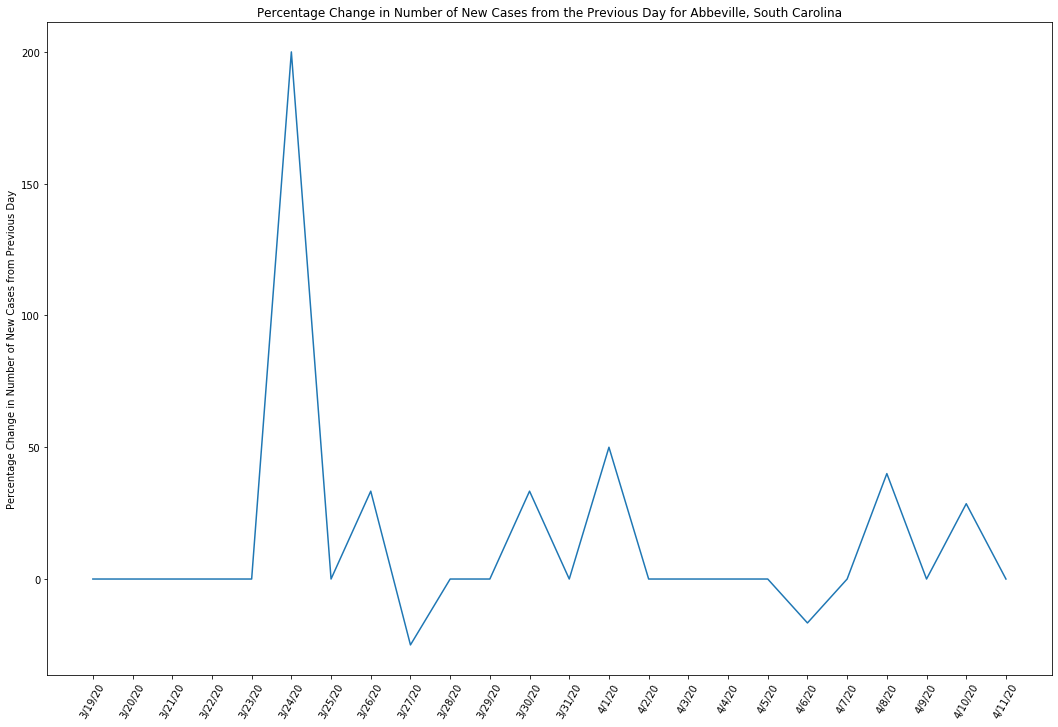

In [10]:
daily_change('Abbeville', 'South Carolina', 'percentage')

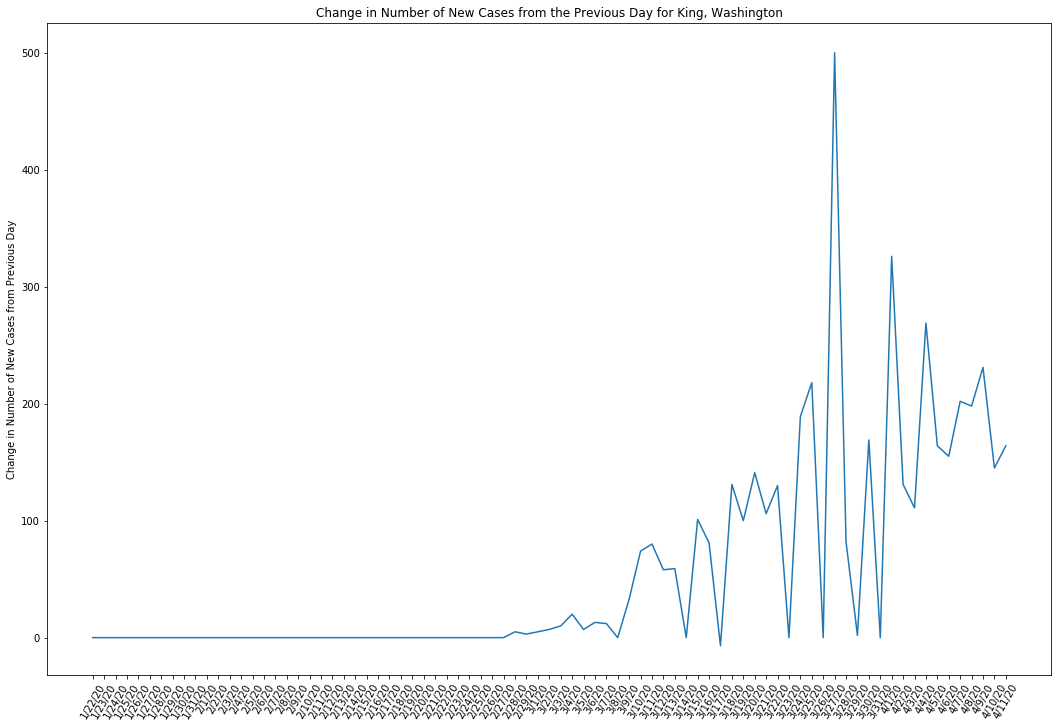

In [11]:
daily_change('King', 'Washington', 'daily')

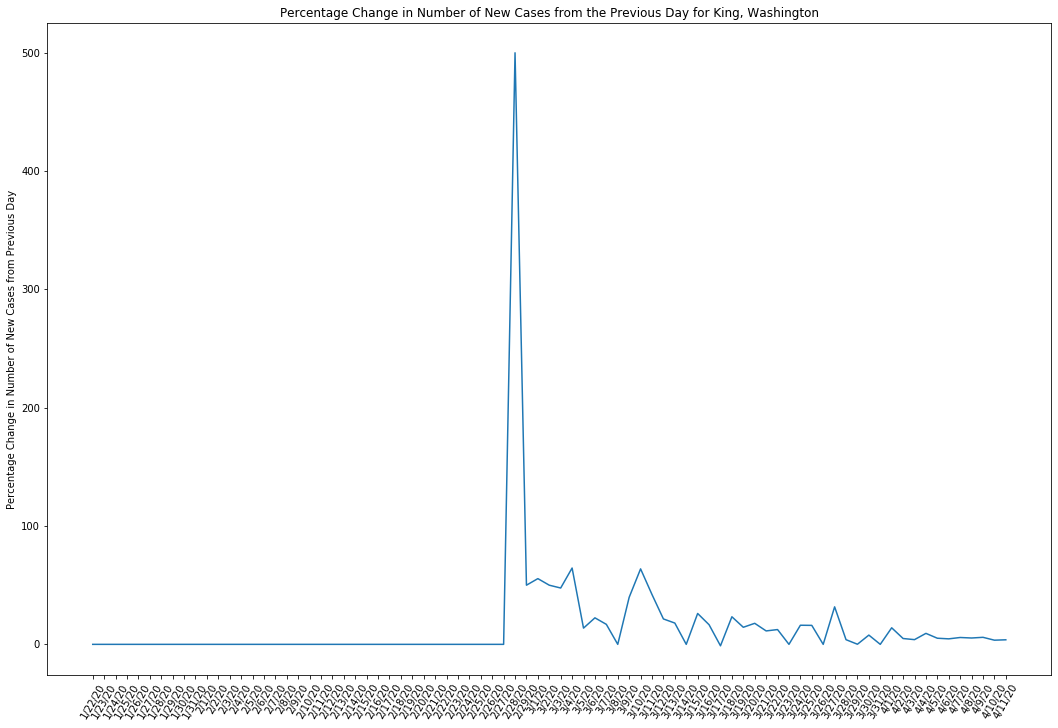

In [12]:
daily_change('King', 'Washington', 'percentage')

In [13]:
# Return the compound average growth rate
def cagr(county, state):
    # Boolean mask of when the county had its first case
    first_occur = [USA[(USA.Admin2 == county) & (USA.Province_State == state)].iloc[0,11:][i] != 0 for i in range(len(dates))]
    # Reduce analysis to only the dates when the county had an infection
    impacted_dates = USA[(USA.Admin2 == county) & (USA.Province_State == state)].iloc[0,11:][first_occur]   
  
    # Numbers needed to calculate cagrt
    start = impacted_dates[0] 
    end = impacted_dates[-1]
    days = len(impacted_dates)
    
    return round(((end / start) ** (1/(days - 1)) - 1),2)*100

In [14]:
cagr('Unassigned', 'Mississippi')

567.0

### Analyze multiple counties

In [15]:
# Group dataframe by county and state to avoid instances like King county Washington and King county Texas
grouped = USA.groupby(['Admin2', 'Province_State']).mean().reset_index()

# Create a new column combining these values
grouped['County_State'] = grouped['Admin2'] + ' ' + grouped['Province_State']

In [16]:
# Create a dictionary of County_State:CAGR(compound average growth rate) pairs
county_cagrs = {}
for i in range(len(grouped.County_State)):
    first_occur = grouped.iloc[i,7:-1] != 0
    impacted_dates = grouped.iloc[i,7:-1][first_occur]
    if len(impacted_dates) > 0:
        start = impacted_dates[0] 
        end = impacted_dates[-1]
        days = len(impacted_dates)
        if end > 0:
            if days > 2:
                county_cagrs.update({grouped.County_State[i]: round(((end / start) ** (1/(days - 1)) - 1),2)*100})

In [17]:
# Turn dict into a counter object
county_cagrs = Counter(county_cagrs)

# Print the top n values
for k, v in county_cagrs.most_common(10):
    print(k,v)

Unassigned Mississippi 567.0
Unassigned Texas 279.0
Polk Wisconsin 73.0
Unassigned Virginia 73.0
Louisa Iowa 62.0
Whitley Kentucky 59.0
Colonial Heights Virginia 56.99999999999999
Custer Nebraska 53.0
Unassigned Connecticut 48.0
Richmond North Carolina 47.0


### Chaning shape of time series

In [18]:
# Only need the 'combined_key' which is County, State, US
# Use melt to turn the n-columns of dates and their values into 1 column of dates and one of values
USA_reshaped = USA.iloc[:,10:].melt(['Combined_Key'], value_name = 'Cases', var_name='Date')
# Show what new df looks like
USA_reshaped.loc[USA_reshaped['Combined_Key'] == 'King, Washington, US']

In [20]:
# Calculate total cases for one county
sum(USA_reshaped.loc[USA_reshaped['Combined_Key'] == 'King, Washington, US']['Cases'])

63836

In [21]:
# Calculate total cases for each county
total_cases_per_county = USA_reshaped.groupby('Combined_Key').sum()
total_cases_per_county

,Cases
Combined_Key,
"Abbeville, South Carolina, US",105
"Acadia, Louisiana, US",1031
"Accomack, Virginia, US",159
"Ada, Idaho, US",5459
"Adair, Iowa, US",26
...,...
"Yuma, Arizona, US",213
"Yuma, Colorado, US",42
"Zapata, Texas, US",15


## Source
###### https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

### Annex

In [22]:
# Pull out county and state from USA_reshaped
# County
[USA_reshaped['Combined_Key'][i].split()[0] for i in range(10)]
# State
[USA_reshaped['Combined_Key'][i].split()[1] for i in range(10)]

['Alabama,',
 'Alabama,',
 'Alabama,',
 'Alabama,',
 'Alabama,',
 'Alabama,',
 'Alabama,',
 'Alabama,',
 'Alabama,',
 'Alabama,']